<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:19:43] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


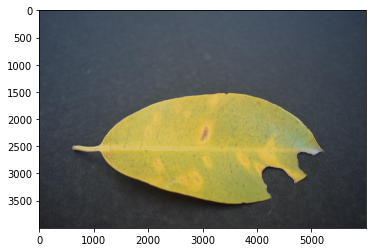

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

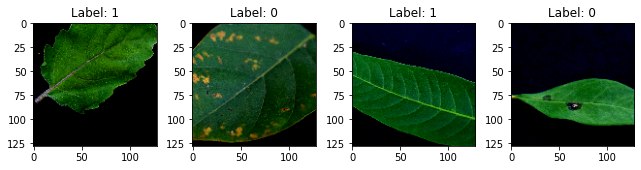

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:19:49] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:19:51] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2591585398812337 samples/sec                   batch loss = 0.500232994556427 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2337681457623475 samples/sec                   batch loss = 0.5451267957687378 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.266758817647595 samples/sec                   batch loss = 0.18433448672294617 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2664519631602118 samples/sec                   batch loss = 0.5137621760368347 | accuracy = 0.65


Epoch[1] Batch[25] Speed: 1.2696133900299438 samples/sec                   batch loss = 1.8253129720687866 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2690788460963867 samples/sec                   batch loss = 0.7123973965644836 | accuracy = 0.6083333333333333


Epoch[1] Batch[35] Speed: 1.2678920909778135 samples/sec                   batch loss = 0.3911941945552826 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.277761927921964 samples/sec                   batch loss = 0.39294806122779846 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2730962269880783 samples/sec                   batch loss = 1.3039991855621338 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.272504213120209 samples/sec                   batch loss = 0.8241222500801086 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.278285600085152 samples/sec                   batch loss = 1.5507291555404663 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2731667530256767 samples/sec                   batch loss = 0.637169599533081 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.270624933873749 samples/sec                   batch loss = 0.7437004446983337 | accuracy = 0.5692307692307692


Epoch[1] Batch[70] Speed: 1.2671273542136898 samples/sec                   batch loss = 0.8658685088157654 | accuracy = 0.5678571428571428


Epoch[1] Batch[75] Speed: 1.264003135368495 samples/sec                   batch loss = 0.27946946024894714 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2717349646583969 samples/sec                   batch loss = 0.9098275899887085 | accuracy = 0.571875


Epoch[1] Batch[85] Speed: 1.2728731070267882 samples/sec                   batch loss = 0.5630479454994202 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.2719961636658978 samples/sec                   batch loss = 0.36081790924072266 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.2750122848591714 samples/sec                   batch loss = 0.550976574420929 | accuracy = 0.5947368421052631


Epoch[1] Batch[100] Speed: 1.2670014230077156 samples/sec                   batch loss = 0.623330295085907 | accuracy = 0.6


Epoch[1] Batch[105] Speed: 1.269562278693066 samples/sec                   batch loss = 0.5513518452644348 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2638025163937414 samples/sec                   batch loss = 0.4458419978618622 | accuracy = 0.6136363636363636


Epoch[1] Batch[115] Speed: 1.2695614140629907 samples/sec                   batch loss = 0.5408370494842529 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2669254553438503 samples/sec                   batch loss = 0.8616889715194702 | accuracy = 0.60625


Epoch[1] Batch[125] Speed: 1.272529597290564 samples/sec                   batch loss = 0.5380150675773621 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.2718120886771445 samples/sec                   batch loss = 0.608056366443634 | accuracy = 0.6019230769230769


Epoch[1] Batch[135] Speed: 1.2761188353536577 samples/sec                   batch loss = 0.3599301278591156 | accuracy = 0.6129629629629629


Epoch[1] Batch[140] Speed: 1.2713280012051582 samples/sec                   batch loss = 0.7240695357322693 | accuracy = 0.6107142857142858


Epoch[1] Batch[145] Speed: 1.2781384534396238 samples/sec                   batch loss = 0.8022485971450806 | accuracy = 0.6086206896551725


Epoch[1] Batch[150] Speed: 1.2785574868686056 samples/sec                   batch loss = 0.40964239835739136 | accuracy = 0.6033333333333334


Epoch[1] Batch[155] Speed: 1.280288150790774 samples/sec                   batch loss = 0.44954198598861694 | accuracy = 0.6064516129032258


Epoch[1] Batch[160] Speed: 1.2751597786478206 samples/sec                   batch loss = 0.4943595230579376 | accuracy = 0.6109375


Epoch[1] Batch[165] Speed: 1.27576813910279 samples/sec                   batch loss = 0.7337402105331421 | accuracy = 0.6136363636363636


Epoch[1] Batch[170] Speed: 1.2679540879108555 samples/sec                   batch loss = 0.4252232015132904 | accuracy = 0.6161764705882353


Epoch[1] Batch[175] Speed: 1.2642277289639758 samples/sec                   batch loss = 0.7605493664741516 | accuracy = 0.6171428571428571


Epoch[1] Batch[180] Speed: 1.262104332715216 samples/sec                   batch loss = 0.28662386536598206 | accuracy = 0.6194444444444445


Epoch[1] Batch[185] Speed: 1.264389318071325 samples/sec                   batch loss = 0.5224614143371582 | accuracy = 0.6229729729729729


Epoch[1] Batch[190] Speed: 1.2728043516193395 samples/sec                   batch loss = 0.2983804941177368 | accuracy = 0.6236842105263158


Epoch[1] Batch[195] Speed: 1.2731283974853438 samples/sec                   batch loss = 0.4048861563205719 | accuracy = 0.6282051282051282


Epoch[1] Batch[200] Speed: 1.2787793877471845 samples/sec                   batch loss = 0.5506343841552734 | accuracy = 0.63


Epoch[1] Batch[205] Speed: 1.2665884945690726 samples/sec                   batch loss = 0.3884662985801697 | accuracy = 0.6329268292682927


Epoch[1] Batch[210] Speed: 1.2721909033720624 samples/sec                   batch loss = 0.5613119602203369 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.2680657360079397 samples/sec                   batch loss = 0.1444954127073288 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.2662000118942929 samples/sec                   batch loss = 0.8075605630874634 | accuracy = 0.6386363636363637


Epoch[1] Batch[225] Speed: 1.2677119797277503 samples/sec                   batch loss = 0.4966789484024048 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.2654433275066517 samples/sec                   batch loss = 0.458128958940506 | accuracy = 0.6358695652173914


Epoch[1] Batch[235] Speed: 1.2768278029955484 samples/sec                   batch loss = 0.32305341958999634 | accuracy = 0.6372340425531915


Epoch[1] Batch[240] Speed: 1.2722862212046289 samples/sec                   batch loss = 0.2220958173274994 | accuracy = 0.6395833333333333


Epoch[1] Batch[245] Speed: 1.2727619625908235 samples/sec                   batch loss = 0.6115468740463257 | accuracy = 0.639795918367347


Epoch[1] Batch[250] Speed: 1.2705372735107332 samples/sec                   batch loss = 0.4020466208457947 | accuracy = 0.641


Epoch[1] Batch[255] Speed: 1.2732922700534879 samples/sec                   batch loss = 0.2559071481227875 | accuracy = 0.6450980392156863


Epoch[1] Batch[260] Speed: 1.2770797246165309 samples/sec                   batch loss = 0.9058183431625366 | accuracy = 0.6451923076923077


Epoch[1] Batch[265] Speed: 1.2738180871184082 samples/sec                   batch loss = 0.654507040977478 | accuracy = 0.6471698113207547


Epoch[1] Batch[270] Speed: 1.275062866926403 samples/sec                   batch loss = 0.3119717240333557 | accuracy = 0.6472222222222223


Epoch[1] Batch[275] Speed: 1.2727586797314747 samples/sec                   batch loss = 0.28077736496925354 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2782042805768934 samples/sec                   batch loss = 0.32557034492492676 | accuracy = 0.6464285714285715


Epoch[1] Batch[285] Speed: 1.2800278326364365 samples/sec                   batch loss = 0.459105908870697 | accuracy = 0.65


Epoch[1] Batch[290] Speed: 1.2733808908951971 samples/sec                   batch loss = 0.3632954955101013 | accuracy = 0.6525862068965518


Epoch[1] Batch[295] Speed: 1.2738383009249161 samples/sec                   batch loss = 0.25415897369384766 | accuracy = 0.6533898305084745


Epoch[1] Batch[300] Speed: 1.2775136281848911 samples/sec                   batch loss = 1.3228321075439453 | accuracy = 0.6533333333333333


Epoch[1] Batch[305] Speed: 1.2762132865199245 samples/sec                   batch loss = 0.657606303691864 | accuracy = 0.6524590163934426


Epoch[1] Batch[310] Speed: 1.2734102728282626 samples/sec                   batch loss = 0.5405232310295105 | accuracy = 0.6540322580645161


Epoch[1] Batch[315] Speed: 1.2709561509485876 samples/sec                   batch loss = 0.965184211730957 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.2680758955231382 samples/sec                   batch loss = 0.42528945207595825 | accuracy = 0.65078125


Epoch[1] Batch[325] Speed: 1.274341338000921 samples/sec                   batch loss = 0.5330864787101746 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2686004818154735 samples/sec                   batch loss = 0.44675198197364807 | accuracy = 0.6530303030303031


Epoch[1] Batch[335] Speed: 1.2760734105838267 samples/sec                   batch loss = 0.7666018605232239 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2743680539024085 samples/sec                   batch loss = 0.38846054673194885 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.2734251576144107 samples/sec                   batch loss = 0.48718783259391785 | accuracy = 0.6550724637681159


Epoch[1] Batch[350] Speed: 1.2711864971833773 samples/sec                   batch loss = 1.4171628952026367 | accuracy = 0.655


Epoch[1] Batch[355] Speed: 1.271785287020134 samples/sec                   batch loss = 0.1857551634311676 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.2727462243309047 samples/sec                   batch loss = 0.2336919903755188 | accuracy = 0.6569444444444444


Epoch[1] Batch[365] Speed: 1.2748907880162872 samples/sec                   batch loss = 0.5216200351715088 | accuracy = 0.6575342465753424


Epoch[1] Batch[370] Speed: 1.2756762757453928 samples/sec                   batch loss = 0.6137002110481262 | accuracy = 0.6594594594594595


Epoch[1] Batch[375] Speed: 1.2695493093655923 samples/sec                   batch loss = 0.440430611371994 | accuracy = 0.6613333333333333


Epoch[1] Batch[380] Speed: 1.273508190175888 samples/sec                   batch loss = 0.8598007559776306 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.2743483072585344 samples/sec                   batch loss = 0.24780288338661194 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.2673685689540624 samples/sec                   batch loss = 0.40297961235046387 | accuracy = 0.6673076923076923


Epoch[1] Batch[395] Speed: 1.2758085942172555 samples/sec                   batch loss = 0.1701040267944336 | accuracy = 0.6677215189873418


Epoch[1] Batch[400] Speed: 1.2751902119675254 samples/sec                   batch loss = 0.2456320822238922 | accuracy = 0.669375


Epoch[1] Batch[405] Speed: 1.2705820163120425 samples/sec                   batch loss = 0.8447771072387695 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2743698930817653 samples/sec                   batch loss = 0.5644445419311523 | accuracy = 0.6695121951219513


Epoch[1] Batch[415] Speed: 1.2795437173969182 samples/sec                   batch loss = 0.9189138412475586 | accuracy = 0.6704819277108434


Epoch[1] Batch[420] Speed: 1.2772228354788857 samples/sec                   batch loss = 1.4333252906799316 | accuracy = 0.6696428571428571


Epoch[1] Batch[425] Speed: 1.27796447263373 samples/sec                   batch loss = 0.5377081632614136 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.2762252273853094 samples/sec                   batch loss = 0.6322091817855835 | accuracy = 0.6709302325581395


Epoch[1] Batch[435] Speed: 1.2824854809713466 samples/sec                   batch loss = 0.7998424172401428 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.2706912404701278 samples/sec                   batch loss = 0.6139641404151917 | accuracy = 0.6698863636363637


Epoch[1] Batch[445] Speed: 1.2756161400582182 samples/sec                   batch loss = 1.1638221740722656 | accuracy = 0.6724719101123595


Epoch[1] Batch[450] Speed: 1.276712274977317 samples/sec                   batch loss = 0.25830256938934326 | accuracy = 0.6727777777777778


Epoch[1] Batch[455] Speed: 1.2763502801133235 samples/sec                   batch loss = 0.5570023059844971 | accuracy = 0.6747252747252748


Epoch[1] Batch[460] Speed: 1.2807890603379997 samples/sec                   batch loss = 0.8628738522529602 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2710165220929555 samples/sec                   batch loss = 0.6271296739578247 | accuracy = 0.6725806451612903


Epoch[1] Batch[470] Speed: 1.2756682249940463 samples/sec                   batch loss = 0.8543974161148071 | accuracy = 0.6728723404255319


Epoch[1] Batch[475] Speed: 1.275026625727315 samples/sec                   batch loss = 0.6986565589904785 | accuracy = 0.6742105263157895


Epoch[1] Batch[480] Speed: 1.2773966143981614 samples/sec                   batch loss = 0.523987889289856 | accuracy = 0.6744791666666666


Epoch[1] Batch[485] Speed: 1.274640794407729 samples/sec                   batch loss = 0.5771934390068054 | accuracy = 0.6737113402061856


Epoch[1] Batch[490] Speed: 1.2759570486307765 samples/sec                   batch loss = 0.837490439414978 | accuracy = 0.6719387755102041


Epoch[1] Batch[495] Speed: 1.2714337885715512 samples/sec                   batch loss = 0.7276638746261597 | accuracy = 0.6712121212121213


Epoch[1] Batch[500] Speed: 1.2762919255967218 samples/sec                   batch loss = 0.47271186113357544 | accuracy = 0.673


Epoch[1] Batch[505] Speed: 1.2778525346541727 samples/sec                   batch loss = 0.7719488739967346 | accuracy = 0.6717821782178218


Epoch[1] Batch[510] Speed: 1.2722879578968123 samples/sec                   batch loss = 0.29194796085357666 | accuracy = 0.6725490196078432


Epoch[1] Batch[515] Speed: 1.2712584493422874 samples/sec                   batch loss = 0.24496832489967346 | accuracy = 0.6737864077669903


Epoch[1] Batch[520] Speed: 1.2608570440847124 samples/sec                   batch loss = 0.42211291193962097 | accuracy = 0.6740384615384616


Epoch[1] Batch[525] Speed: 1.2608972223792134 samples/sec                   batch loss = 0.6421381831169128 | accuracy = 0.6747619047619048


Epoch[1] Batch[530] Speed: 1.2637437805089786 samples/sec                   batch loss = 0.7630383968353271 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2668156340720618 samples/sec                   batch loss = 0.5777662992477417 | accuracy = 0.6766355140186916


Epoch[1] Batch[540] Speed: 1.265740239527147 samples/sec                   batch loss = 0.5126030445098877 | accuracy = 0.6759259259259259


Epoch[1] Batch[545] Speed: 1.25966461232682 samples/sec                   batch loss = 0.6568742394447327 | accuracy = 0.6752293577981652


Epoch[1] Batch[550] Speed: 1.25830265055412 samples/sec                   batch loss = 0.6861838102340698 | accuracy = 0.675


Epoch[1] Batch[555] Speed: 1.2649017981549726 samples/sec                   batch loss = 0.6060667037963867 | accuracy = 0.6747747747747748


Epoch[1] Batch[560] Speed: 1.265520740333302 samples/sec                   batch loss = 0.6107048392295837 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2620445204036805 samples/sec                   batch loss = 0.42011770606040955 | accuracy = 0.6756637168141593


Epoch[1] Batch[570] Speed: 1.2620100596936539 samples/sec                   batch loss = 0.4071396589279175 | accuracy = 0.6771929824561403


Epoch[1] Batch[575] Speed: 1.2675726202399207 samples/sec                   batch loss = 0.7006016373634338 | accuracy = 0.6769565217391305


Epoch[1] Batch[580] Speed: 1.2649025610837084 samples/sec                   batch loss = 0.84012371301651 | accuracy = 0.6771551724137931


Epoch[1] Batch[585] Speed: 1.2715305348703874 samples/sec                   batch loss = 0.10158255696296692 | accuracy = 0.6777777777777778


Epoch[1] Batch[590] Speed: 1.2595622872822108 samples/sec                   batch loss = 0.4718300998210907 | accuracy = 0.6783898305084746


Epoch[1] Batch[595] Speed: 1.2611133193861224 samples/sec                   batch loss = 0.4082357883453369 | accuracy = 0.6789915966386555


Epoch[1] Batch[600] Speed: 1.259754089436358 samples/sec                   batch loss = 0.7573792338371277 | accuracy = 0.68


Epoch[1] Batch[605] Speed: 1.2548715495403475 samples/sec                   batch loss = 0.7444887757301331 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2601296346271984 samples/sec                   batch loss = 0.5277643203735352 | accuracy = 0.680327868852459


Epoch[1] Batch[615] Speed: 1.2566227819324283 samples/sec                   batch loss = 0.8088243007659912 | accuracy = 0.6804878048780488


Epoch[1] Batch[620] Speed: 1.256181788136816 samples/sec                   batch loss = 0.28206855058670044 | accuracy = 0.682258064516129


Epoch[1] Batch[625] Speed: 1.2667426536365323 samples/sec                   batch loss = 0.5595231652259827 | accuracy = 0.682


Epoch[1] Batch[630] Speed: 1.2664403000768898 samples/sec                   batch loss = 0.438016414642334 | accuracy = 0.6825396825396826


Epoch[1] Batch[635] Speed: 1.268837651676974 samples/sec                   batch loss = 0.4021945893764496 | accuracy = 0.6834645669291338


Epoch[1] Batch[640] Speed: 1.2657157939184411 samples/sec                   batch loss = 0.31191587448120117 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.2616830139885808 samples/sec                   batch loss = 0.3018400967121124 | accuracy = 0.6844961240310078


Epoch[1] Batch[650] Speed: 1.271683682364081 samples/sec                   batch loss = 0.3644697368144989 | accuracy = 0.6861538461538461


Epoch[1] Batch[655] Speed: 1.267548391098581 samples/sec                   batch loss = 0.35371705889701843 | accuracy = 0.6866412213740458


Epoch[1] Batch[660] Speed: 1.2621612071393002 samples/sec                   batch loss = 0.5454192161560059 | accuracy = 0.6867424242424243


Epoch[1] Batch[665] Speed: 1.2630112308460757 samples/sec                   batch loss = 0.5219652056694031 | accuracy = 0.687218045112782


Epoch[1] Batch[670] Speed: 1.2594529824036182 samples/sec                   batch loss = 0.5300922989845276 | accuracy = 0.6880597014925374


Epoch[1] Batch[675] Speed: 1.263816415797404 samples/sec                   batch loss = 0.4096446931362152 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2615664156499897 samples/sec                   batch loss = 0.47133129835128784 | accuracy = 0.6863970588235294


Epoch[1] Batch[685] Speed: 1.2628210020754949 samples/sec                   batch loss = 0.6075507998466492 | accuracy = 0.6857664233576642


Epoch[1] Batch[690] Speed: 1.2637994699899513 samples/sec                   batch loss = 0.3074204921722412 | accuracy = 0.686231884057971


Epoch[1] Batch[695] Speed: 1.2651733635456794 samples/sec                   batch loss = 0.34475138783454895 | accuracy = 0.6866906474820144


Epoch[1] Batch[700] Speed: 1.2646660019158573 samples/sec                   batch loss = 0.6045262217521667 | accuracy = 0.6857142857142857


Epoch[1] Batch[705] Speed: 1.263443903270709 samples/sec                   batch loss = 0.5020742416381836 | accuracy = 0.6868794326241134


Epoch[1] Batch[710] Speed: 1.2694556498674985 samples/sec                   batch loss = 0.7408944368362427 | accuracy = 0.6866197183098591


Epoch[1] Batch[715] Speed: 1.2712758847593435 samples/sec                   batch loss = 0.27408474683761597 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2719288529596546 samples/sec                   batch loss = 0.6473019123077393 | accuracy = 0.6875


Epoch[1] Batch[725] Speed: 1.271787407973414 samples/sec                   batch loss = 0.2173568457365036 | accuracy = 0.6879310344827586


Epoch[1] Batch[730] Speed: 1.2603808799895007 samples/sec                   batch loss = 0.5492921471595764 | accuracy = 0.6883561643835616


Epoch[1] Batch[735] Speed: 1.2596416303008047 samples/sec                   batch loss = 0.285910964012146 | accuracy = 0.6894557823129251


Epoch[1] Batch[740] Speed: 1.2566865055838574 samples/sec                   batch loss = 0.9691277146339417 | accuracy = 0.6895270270270271


Epoch[1] Batch[745] Speed: 1.262069963678249 samples/sec                   batch loss = 0.6757509112358093 | accuracy = 0.6899328859060403


Epoch[1] Batch[750] Speed: 1.2615676488800978 samples/sec                   batch loss = 0.6128950119018555 | accuracy = 0.689


Epoch[1] Batch[755] Speed: 1.2621347157431166 samples/sec                   batch loss = 0.7082818150520325 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2629837529850283 samples/sec                   batch loss = 0.34521177411079407 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.2600137017309514 samples/sec                   batch loss = 0.4106079936027527 | accuracy = 0.6895424836601307


Epoch[1] Batch[770] Speed: 1.2637227435378628 samples/sec                   batch loss = 0.3574438691139221 | accuracy = 0.6902597402597402


Epoch[1] Batch[775] Speed: 1.2651228952624898 samples/sec                   batch loss = 0.3426967263221741 | accuracy = 0.6909677419354838


Epoch[1] Batch[780] Speed: 1.2637915684485694 samples/sec                   batch loss = 0.8591015338897705 | accuracy = 0.691025641025641


Epoch[1] Batch[785] Speed: 1.269107165820707 samples/sec                   batch loss = 1.2737425565719604 | accuracy = 0.6910828025477707


[Epoch 1] training: accuracy=0.690989847715736
[Epoch 1] time cost: 647.6859180927277
[Epoch 1] validation: validation accuracy=0.7411111111111112


Epoch[2] Batch[5] Speed: 1.2778911753751097 samples/sec                   batch loss = 0.5022200345993042 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2761382486348074 samples/sec                   batch loss = 0.5565413236618042 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.277844943049156 samples/sec                   batch loss = 0.26097771525382996 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2648302776733 samples/sec                   batch loss = 0.660531759262085 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2689293964884 samples/sec                   batch loss = 0.32506951689720154 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2650766282571515 samples/sec                   batch loss = 0.3799656927585602 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2683404836112364 samples/sec                   batch loss = 0.2584061026573181 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2714223226056387 samples/sec                   batch loss = 0.510543942451477 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2720637708437366 samples/sec                   batch loss = 0.6449459791183472 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2674988822551987 samples/sec                   batch loss = 0.5496581792831421 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2727423622407077 samples/sec                   batch loss = 0.5871222615242004 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.265542696373083 samples/sec                   batch loss = 0.5064282417297363 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2714884233670751 samples/sec                   batch loss = 0.7562599182128906 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2666042721543236 samples/sec                   batch loss = 0.5723558664321899 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.27098879109439 samples/sec                   batch loss = 0.4446130692958832 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2653789990216953 samples/sec                   batch loss = 0.6114344596862793 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.268418539009624 samples/sec                   batch loss = 0.2563609480857849 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.273692176319181 samples/sec                   batch loss = 0.47546979784965515 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2717559800263278 samples/sec                   batch loss = 0.2652989327907562 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2684050176691375 samples/sec                   batch loss = 0.25557443499565125 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.266524527660073 samples/sec                   batch loss = 1.4447568655014038 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2750273040196092 samples/sec                   batch loss = 0.9536179304122925 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2674871041250255 samples/sec                   batch loss = 0.19091328978538513 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2739253533546433 samples/sec                   batch loss = 0.5575589537620544 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2734659475779335 samples/sec                   batch loss = 0.232302725315094 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.2652379573740131 samples/sec                   batch loss = 1.2812577486038208 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.267855681385629 samples/sec                   batch loss = 0.27574872970581055 | accuracy = 0.7574074074074074


Epoch[2] Batch[140] Speed: 1.2641140887269027 samples/sec                   batch loss = 0.28117942810058594 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.2698599735707221 samples/sec                   batch loss = 0.33542174100875854 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.2660294568971835 samples/sec                   batch loss = 0.6704729199409485 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.266185773332797 samples/sec                   batch loss = 1.0104353427886963 | accuracy = 0.7548387096774194


Epoch[2] Batch[160] Speed: 1.2813634625405925 samples/sec                   batch loss = 0.17338567972183228 | accuracy = 0.7578125


Epoch[2] Batch[165] Speed: 1.2703240908861004 samples/sec                   batch loss = 0.4858852028846741 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2765373223907257 samples/sec                   batch loss = 0.5161855220794678 | accuracy = 0.7529411764705882


Epoch[2] Batch[175] Speed: 1.2728183531716302 samples/sec                   batch loss = 0.3874681293964386 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.275128959122979 samples/sec                   batch loss = 0.4809305965900421 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2772648414939078 samples/sec                   batch loss = 0.6741830110549927 | accuracy = 0.75


Epoch[2] Batch[190] Speed: 1.276164942860844 samples/sec                   batch loss = 0.4270593822002411 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.2743780242541163 samples/sec                   batch loss = 0.34475985169410706 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2788404069338677 samples/sec                   batch loss = 0.24115251004695892 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.2710909588464883 samples/sec                   batch loss = 0.5813633799552917 | accuracy = 0.7475609756097561


Epoch[2] Batch[210] Speed: 1.275135646251813 samples/sec                   batch loss = 0.3928225338459015 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2727179350631665 samples/sec                   batch loss = 0.897181510925293 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2734359831319912 samples/sec                   batch loss = 0.5643667578697205 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2746770136761807 samples/sec                   batch loss = 0.5628940463066101 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.272946216078188 samples/sec                   batch loss = 0.4061014652252197 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.275993730925843 samples/sec                   batch loss = 0.21640431880950928 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2721598413342818 samples/sec                   batch loss = 0.3950425684452057 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.277707823047551 samples/sec                   batch loss = 0.2191230058670044 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.274981181787542 samples/sec                   batch loss = 0.9485117197036743 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2758453650002335 samples/sec                   batch loss = 0.7180285453796387 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.272271941915319 samples/sec                   batch loss = 0.5297766327857971 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2669339701576212 samples/sec                   batch loss = 0.30591556429862976 | accuracy = 0.7490566037735849


Epoch[2] Batch[270] Speed: 1.2736082496139827 samples/sec                   batch loss = 0.2784065902233124 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.2726490998799354 samples/sec                   batch loss = 0.5506308078765869 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2729176281837042 samples/sec                   batch loss = 0.47628462314605713 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2729557778564844 samples/sec                   batch loss = 0.541985034942627 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.2800954172685755 samples/sec                   batch loss = 0.581260085105896 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.2771166659257451 samples/sec                   batch loss = 0.21040146052837372 | accuracy = 0.7483050847457627


Epoch[2] Batch[300] Speed: 1.2694093535583748 samples/sec                   batch loss = 0.47209376096725464 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.2668825959968173 samples/sec                   batch loss = 0.7014992833137512 | accuracy = 0.75


Epoch[2] Batch[310] Speed: 1.2705834596806806 samples/sec                   batch loss = 0.33332985639572144 | accuracy = 0.7532258064516129


Epoch[2] Batch[315] Speed: 1.265238434457843 samples/sec                   batch loss = 0.16005274653434753 | accuracy = 0.753968253968254


Epoch[2] Batch[320] Speed: 1.269247247042931 samples/sec                   batch loss = 0.3747759163379669 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.2723394819217426 samples/sec                   batch loss = 0.1554529070854187 | accuracy = 0.7523076923076923


Epoch[2] Batch[330] Speed: 1.2687530202164499 samples/sec                   batch loss = 0.19088612496852875 | accuracy = 0.7553030303030303


Epoch[2] Batch[335] Speed: 1.2626747331705432 samples/sec                   batch loss = 0.3257288634777069 | accuracy = 0.7574626865671642


Epoch[2] Batch[340] Speed: 1.2729964411644887 samples/sec                   batch loss = 0.5587095022201538 | accuracy = 0.7573529411764706


Epoch[2] Batch[345] Speed: 1.2683661813793965 samples/sec                   batch loss = 0.5964195132255554 | accuracy = 0.7572463768115942


Epoch[2] Batch[350] Speed: 1.26909074982653 samples/sec                   batch loss = 0.10336670279502869 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2695601651549608 samples/sec                   batch loss = 0.48499083518981934 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.2701313645806205 samples/sec                   batch loss = 0.3699183762073517 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.271162611252762 samples/sec                   batch loss = 0.6212820410728455 | accuracy = 0.7575342465753425


Epoch[2] Batch[370] Speed: 1.2773959335826623 samples/sec                   batch loss = 0.3733646273612976 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.2705862502026801 samples/sec                   batch loss = 0.5181825757026672 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2762071705534561 samples/sec                   batch loss = 0.3547789752483368 | accuracy = 0.7585526315789474


Epoch[2] Batch[385] Speed: 1.2753077912724218 samples/sec                   batch loss = 0.6060670614242554 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.273282799853404 samples/sec                   batch loss = 0.24827592074871063 | accuracy = 0.7544871794871795


Epoch[2] Batch[395] Speed: 1.2655873744933228 samples/sec                   batch loss = 0.7318578958511353 | accuracy = 0.7550632911392405


Epoch[2] Batch[400] Speed: 1.2632312870133409 samples/sec                   batch loss = 0.41036444902420044 | accuracy = 0.75625


Epoch[2] Batch[405] Speed: 1.2740569218248525 samples/sec                   batch loss = 0.5901091694831848 | accuracy = 0.7555555555555555


Epoch[2] Batch[410] Speed: 1.2703579490506474 samples/sec                   batch loss = 0.9306138157844543 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.2740158037586817 samples/sec                   batch loss = 0.7840339541435242 | accuracy = 0.7542168674698795


Epoch[2] Batch[420] Speed: 1.2665858171996773 samples/sec                   batch loss = 0.3037937879562378 | accuracy = 0.7541666666666667


Epoch[2] Batch[425] Speed: 1.2707097190129415 samples/sec                   batch loss = 0.22015684843063354 | accuracy = 0.7541176470588236


Epoch[2] Batch[430] Speed: 1.2633206056632058 samples/sec                   batch loss = 0.20147158205509186 | accuracy = 0.7540697674418605


Epoch[2] Batch[435] Speed: 1.2667290723603533 samples/sec                   batch loss = 0.5427771806716919 | accuracy = 0.7545977011494253


Epoch[2] Batch[440] Speed: 1.2727301002596785 samples/sec                   batch loss = 0.36140406131744385 | accuracy = 0.7534090909090909


Epoch[2] Batch[445] Speed: 1.2696504771476829 samples/sec                   batch loss = 0.37199562788009644 | accuracy = 0.7544943820224719


Epoch[2] Batch[450] Speed: 1.2691516159366838 samples/sec                   batch loss = 0.5619144439697266 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.2694600683639747 samples/sec                   batch loss = 0.5530350804328918 | accuracy = 0.7543956043956044


Epoch[2] Batch[460] Speed: 1.2718561499711132 samples/sec                   batch loss = 0.1741749793291092 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2756079930786404 samples/sec                   batch loss = 0.22319042682647705 | accuracy = 0.7553763440860215


Epoch[2] Batch[470] Speed: 1.2746374050093205 samples/sec                   batch loss = 0.3244173228740692 | accuracy = 0.7574468085106383


Epoch[2] Batch[475] Speed: 1.2682161326323675 samples/sec                   batch loss = 0.5674179196357727 | accuracy = 0.7573684210526316


Epoch[2] Batch[480] Speed: 1.2706023199989336 samples/sec                   batch loss = 0.7136261463165283 | accuracy = 0.7572916666666667


Epoch[2] Batch[485] Speed: 1.2739167443064772 samples/sec                   batch loss = 0.5645933747291565 | accuracy = 0.7572164948453608


Epoch[2] Batch[490] Speed: 1.270987924520183 samples/sec                   batch loss = 0.2759571969509125 | accuracy = 0.7586734693877552


Epoch[2] Batch[495] Speed: 1.2761590214997738 samples/sec                   batch loss = 0.3213094174861908 | accuracy = 0.7580808080808081


Epoch[2] Batch[500] Speed: 1.2755361295879972 samples/sec                   batch loss = 0.6974694728851318 | accuracy = 0.757


Epoch[2] Batch[505] Speed: 1.2683791265450635 samples/sec                   batch loss = 0.7049023509025574 | accuracy = 0.7574257425742574


Epoch[2] Batch[510] Speed: 1.2716021404660778 samples/sec                   batch loss = 0.14942914247512817 | accuracy = 0.7578431372549019


Epoch[2] Batch[515] Speed: 1.2719803479026544 samples/sec                   batch loss = 0.3874189257621765 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.2765862770834522 samples/sec                   batch loss = 0.32507169246673584 | accuracy = 0.7581730769230769


Epoch[2] Batch[525] Speed: 1.2722419371558338 samples/sec                   batch loss = 0.523644208908081 | accuracy = 0.7585714285714286


Epoch[2] Batch[530] Speed: 1.2709825325294462 samples/sec                   batch loss = 0.32079195976257324 | accuracy = 0.7580188679245283


Epoch[2] Batch[535] Speed: 1.2745667159510006 samples/sec                   batch loss = 0.6095867156982422 | accuracy = 0.7593457943925234


Epoch[2] Batch[540] Speed: 1.2726939915461801 samples/sec                   batch loss = 0.46562615036964417 | accuracy = 0.7597222222222222


Epoch[2] Batch[545] Speed: 1.271325111087014 samples/sec                   batch loss = 0.33457252383232117 | accuracy = 0.7600917431192661


Epoch[2] Batch[550] Speed: 1.2707355128776103 samples/sec                   batch loss = 0.6384786367416382 | accuracy = 0.7609090909090909


Epoch[2] Batch[555] Speed: 1.274728634533008 samples/sec                   batch loss = 0.40261900424957275 | accuracy = 0.7599099099099099


Epoch[2] Batch[560] Speed: 1.2697450302764863 samples/sec                   batch loss = 0.13738974928855896 | accuracy = 0.7607142857142857


Epoch[2] Batch[565] Speed: 1.2704501062645097 samples/sec                   batch loss = 0.5368372797966003 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.275968596533231 samples/sec                   batch loss = 0.3457890748977661 | accuracy = 0.7614035087719299


Epoch[2] Batch[575] Speed: 1.2742439699574857 samples/sec                   batch loss = 0.4876451790332794 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.2674676659011241 samples/sec                   batch loss = 0.9801128506660461 | accuracy = 0.7607758620689655


Epoch[2] Batch[585] Speed: 1.273655046089974 samples/sec                   batch loss = 0.41798144578933716 | accuracy = 0.7606837606837606


Epoch[2] Batch[590] Speed: 1.2680583560848255 samples/sec                   batch loss = 0.651250422000885 | accuracy = 0.7610169491525424


Epoch[2] Batch[595] Speed: 1.2695590123189604 samples/sec                   batch loss = 0.28214937448501587 | accuracy = 0.761344537815126


Epoch[2] Batch[600] Speed: 1.2697363815393288 samples/sec                   batch loss = 0.21875980496406555 | accuracy = 0.76125


Epoch[2] Batch[605] Speed: 1.2672513003189048 samples/sec                   batch loss = 0.28694948554039 | accuracy = 0.7615702479338843


Epoch[2] Batch[610] Speed: 1.26789554041604 samples/sec                   batch loss = 0.8309100866317749 | accuracy = 0.7614754098360655


Epoch[2] Batch[615] Speed: 1.27384487780411 samples/sec                   batch loss = 0.7015166282653809 | accuracy = 0.7617886178861789


Epoch[2] Batch[620] Speed: 1.2746742051566164 samples/sec                   batch loss = 0.4125300645828247 | accuracy = 0.7616935483870968


Epoch[2] Batch[625] Speed: 1.2724280666850813 samples/sec                   batch loss = 0.7008669972419739 | accuracy = 0.7612


Epoch[2] Batch[630] Speed: 1.274695802021936 samples/sec                   batch loss = 0.5580590963363647 | accuracy = 0.7607142857142857


Epoch[2] Batch[635] Speed: 1.2702214693510492 samples/sec                   batch loss = 0.21008247137069702 | accuracy = 0.7614173228346457


Epoch[2] Batch[640] Speed: 1.272002914416315 samples/sec                   batch loss = 0.7195870876312256 | accuracy = 0.76171875


Epoch[2] Batch[645] Speed: 1.2709004066116878 samples/sec                   batch loss = 0.4258170425891876 | accuracy = 0.7616279069767442


Epoch[2] Batch[650] Speed: 1.270665255928546 samples/sec                   batch loss = 1.1838829517364502 | accuracy = 0.7619230769230769


Epoch[2] Batch[655] Speed: 1.2667169259727233 samples/sec                   batch loss = 0.23284439742565155 | accuracy = 0.7629770992366413


Epoch[2] Batch[660] Speed: 1.2726661873021607 samples/sec                   batch loss = 0.5870519280433655 | accuracy = 0.7640151515151515


Epoch[2] Batch[665] Speed: 1.2759898491017114 samples/sec                   batch loss = 0.43579283356666565 | accuracy = 0.7639097744360902


Epoch[2] Batch[670] Speed: 1.267286047864076 samples/sec                   batch loss = 0.6664142608642578 | accuracy = 0.7634328358208955


Epoch[2] Batch[675] Speed: 1.2692537765998373 samples/sec                   batch loss = 0.39142900705337524 | accuracy = 0.7637037037037037


Epoch[2] Batch[680] Speed: 1.2710819065634622 samples/sec                   batch loss = 0.24358054995536804 | accuracy = 0.7636029411764705


Epoch[2] Batch[685] Speed: 1.2742588742401597 samples/sec                   batch loss = 0.42986252903938293 | accuracy = 0.7631386861313869


Epoch[2] Batch[690] Speed: 1.2673777599029563 samples/sec                   batch loss = 0.6471340656280518 | accuracy = 0.7630434782608696


Epoch[2] Batch[695] Speed: 1.272093960107095 samples/sec                   batch loss = 0.22755223512649536 | accuracy = 0.762589928057554


Epoch[2] Batch[700] Speed: 1.2754123998258826 samples/sec                   batch loss = 0.5728940367698669 | accuracy = 0.7614285714285715


Epoch[2] Batch[705] Speed: 1.2663681275768885 samples/sec                   batch loss = 0.4472731947898865 | accuracy = 0.7609929078014185


Epoch[2] Batch[710] Speed: 1.2656639456160024 samples/sec                   batch loss = 0.5580138564109802 | accuracy = 0.7612676056338028


Epoch[2] Batch[715] Speed: 1.2744224571356864 samples/sec                   batch loss = 0.680965006351471 | accuracy = 0.7611888111888112


Epoch[2] Batch[720] Speed: 1.2732618306259507 samples/sec                   batch loss = 0.5797595977783203 | accuracy = 0.7614583333333333


Epoch[2] Batch[725] Speed: 1.2727132042162168 samples/sec                   batch loss = 0.2888404428958893 | accuracy = 0.7620689655172413


Epoch[2] Batch[730] Speed: 1.2708991550678506 samples/sec                   batch loss = 0.4874163568019867 | accuracy = 0.7616438356164383


Epoch[2] Batch[735] Speed: 1.2733773148972147 samples/sec                   batch loss = 0.832292914390564 | accuracy = 0.7615646258503401


Epoch[2] Batch[740] Speed: 1.2696752671547176 samples/sec                   batch loss = 0.34052759408950806 | accuracy = 0.760472972972973


Epoch[2] Batch[745] Speed: 1.271867720182394 samples/sec                   batch loss = 0.4966491758823395 | accuracy = 0.7607382550335571


Epoch[2] Batch[750] Speed: 1.2680246203873242 samples/sec                   batch loss = 0.5678227543830872 | accuracy = 0.7593333333333333


Epoch[2] Batch[755] Speed: 1.269973784087858 samples/sec                   batch loss = 0.5287712216377258 | accuracy = 0.7599337748344371


Epoch[2] Batch[760] Speed: 1.2705271707336467 samples/sec                   batch loss = 0.39529773592948914 | accuracy = 0.7605263157894737


Epoch[2] Batch[765] Speed: 1.2728652847590665 samples/sec                   batch loss = 0.6976080536842346 | accuracy = 0.7607843137254902


Epoch[2] Batch[770] Speed: 1.273465754254408 samples/sec                   batch loss = 0.86988765001297 | accuracy = 0.7600649350649351


Epoch[2] Batch[775] Speed: 1.2699678239093477 samples/sec                   batch loss = 0.40139973163604736 | accuracy = 0.7593548387096775


Epoch[2] Batch[780] Speed: 1.2694870602820394 samples/sec                   batch loss = 0.5944800972938538 | accuracy = 0.7599358974358974


Epoch[2] Batch[785] Speed: 1.2728333206888705 samples/sec                   batch loss = 0.4020049571990967 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7588832487309645
[Epoch 2] time cost: 637.7812013626099
[Epoch 2] validation: validation accuracy=0.7655555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)